# ABU量化系统使用文档 

<center>
        <img src="./image/abu_logo.png" alt="" style="vertical-align:middle;padding:10px 20px;"><font size="6" color="black"><b>第4节 多支股票择时回测与仓位管理</b></font>
</center>

-----------------

作者: 阿布

阿布量化版权所有 未经允许 禁止转载

[abu量化系统github地址](https://github.com/bbfamily/abu) (您的star是我的动力！)

[本节ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)


首先导入abupy中本节使用的模块：

In [1]:
from __future__ import print_function
from __future__ import division

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/csv


之前的章节无论讲解策略优化，还是针对回测进行滑点或是手续费都是针对一支股票进行择时操作。

本节将示例讲解多支股票进行择时策略的实现，依然使用AbuFactorBuyBreak做为买入策略，其它四个卖出策略同时生效的组合。

In [4]:
from abupy import AbuFactorBuyBreak, AbuFactorSellBreak, AbuPositionBase
from abupy import AbuFactorAtrNStop, AbuFactorPreAtrNStop, AbuFactorCloseAtrNStop
from abupy import ABuPickTimeExecute, AbuBenchmark, AbuCapital

# buy_factors 60日向上突破，42日向上突破两个因子
buy_factors = [{'xd': 60, 'class': AbuFactorBuyBreak}, 
               {'xd': 42, 'class': AbuFactorBuyBreak}]
# 四个卖出因子同时并行生效
sell_factors = [
    {
        'xd': 120,
        'class': AbuFactorSellBreak
    },
    {
        'stop_loss_n': 0.5,
        'stop_win_n': 3.0,
        'class': AbuFactorAtrNStop
    },
    {
        'class': AbuFactorPreAtrNStop,
        'pre_atr_n': 1.0
    },
    {
        'class': AbuFactorCloseAtrNStop,
        'close_atr_n': 1.5
    }]
benchmark = AbuBenchmark()
capital = AbuCapital(1000000, benchmark)

### 1. 多支股票使用相同的因子进行择时

选择的股票如下所示：
choice_symbols = ['usTSLA', 'usNOAH', 'usSFUN', 'usBIDU', 'usAAPL',
                  'usGOOG', 'usWUBA', 'usVIPS']

备注：本节示例都基于美股市场，针对A股市场及港股市场，比特币，期货市场后在后面的章节讲解

In [6]:
# 我们假定choice_symbols是我们选股模块的结果，
choice_symbols = ['usTSLA', 'usNOAH', 'usSFUN', 'usBIDU', 'usAAPL',
                  'usGOOG', 'usWUBA', 'usVIPS']

使用ABuPickTimeExecute.do_symbols_with_same_factors()函数对多支股票使用相同的买入因子，卖出因子

In [7]:
%%time
capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, all_fit_symbols_cnt = ABuPickTimeExecute.do_symbols_with_same_factors(choice_symbols,
                                                                                            benchmark,
                                                                                            buy_factors,
                                                                                            sell_factors,
                                                                                            capital,
                                                                                            show=False)

CPU times: user 22.5 s, sys: 308 ms, total: 22.8 s
Wall time: 23.6 s


运行完毕，使用了ipython的magic code %%time去统计代码块运行时间，显示运行了19.2 s，本节最后会使用多进程模式运行相同的回测，会和这个时间进行比较。

备注：具体实际运行时间根据cpu的性能确定

下面代码显示orders_pd中前10个交易数据：

In [8]:
orders_pd[:10]

,buy_date,buy_price,buy_cnt,buy_factor,symbol,buy_pos,buy_type_str,expect_direction,sell_type_extra,sell_date,sell_price,sell_type,ml_features,key,profit,result
2014-10-24,20141024,105.010,1904.0,AbuFactorBuyBreak:60,usAAPL,AbuAtrPosition,call,1.0,AbuFactorPreAtrNStop:pre_atr=1.0,20141202,114.2500,win,None,64,17592.96,1
2014-10-24,20141024,105.010,1904.0,AbuFactorBuyBreak:42,usAAPL,AbuAtrPosition,call,1.0,AbuFactorPreAtrNStop:pre_atr=1.0,20141202,114.2500,win,None,64,17592.96,1
2014-10-29,20141029,223.680,781.0,AbuFactorBuyBreak:42,usBIDU,AbuAtrPosition,call,1.0,AbuFactorPreAtrNStop:pre_atr=1.0,20141202,235.8100,win,None,67,9473.53,1
2014-10-29,20141029,16.010,9217.0,AbuFactorBuyBreak:42,usNOAH,AbuAtrPosition,call,1.0,AbuFactorAtrNStop:stop_win=3.0,20141208,24.0500,win,None,67,74104.68,1
2014-10-29,20141029,21.430,6095.0,AbuFactorBuyBreak:42,usVIPS,AbuAtrPosition,call,1.0,AbuFactorPreAtrNStop:pre_atr=1.0,20141105,23.4700,win,None,67,12433.80,1
2014-10-29,20141029,223.680,781.0,AbuFactorBuyBreak:60,usBIDU,AbuAtrPosition,call,1.0,AbuFactorPreAtrNStop:pre_atr=1.0,20141202,235.8100,win,None,67,9473.53,1
2014-11-03,20141103,23.364,5900.0,AbuFactorBuyBreak:60,usVIPS,AbuAtrPosition,call,1.0,AbuFactorPreAtrNStop:pre_atr=1.0,20141105,23.4700,win,None,70,625.40,1
2014-11-11,20141111,16.990,9491.0,AbuFactorBuyBreak:60,usNOAH,AbuAtrPosition,call,1.0,AbuFactorCloseAtrNStop:close_atr_n=1.5,20141211,20.1450,win,None,76,29944.10,1
2014-11-12,20141112,43.250,2945.0,AbuFactorBuyBreak:42,usWUBA,AbuAtrPosition,call,1.0,AbuFactorPreAtrNStop:pre_atr=1.0,20141209,42.6425,loss,None,77,-1789.09,-1
2014-11-26,20141126,47.100,3262.0,AbuFactorBuyBreak:60,usWUBA,AbuAtrPosition,call,1.0,AbuFactorAtrNStop:stop_loss=0.5,20141209,42.6425,loss,None,87,-14540.36,-1


通过buy_cnt列可以发现每次交易数量都不一样，由于内部有资金管理控制模块默认使用atr进行仓位控制

默认资金管理控制使用AbuAtrPosition，详情请阅读源代码，下面会有自定义仓位管理的示例。

下面代码显示action_pd中前10个行为数据：

In [10]:
action_pd[:10]

,Date,Price,Cnt,symbol,Direction,Price2,action,deal
0,20141024,105.010,1904.0,usAAPL,1.0,114.250,buy,True
1,20141024,105.010,1904.0,usAAPL,1.0,114.250,buy,True
2,20141029,16.010,9217.0,usNOAH,1.0,24.050,buy,True
3,20141029,223.680,781.0,usBIDU,1.0,235.810,buy,True
4,20141029,223.680,781.0,usBIDU,1.0,235.810,buy,True
5,20141029,21.430,6095.0,usVIPS,1.0,23.470,buy,False
6,20141103,23.364,5900.0,usVIPS,1.0,23.470,buy,False
7,20141105,23.470,6095.0,usVIPS,1.0,21.430,sell,False
8,20141105,23.470,5900.0,usVIPS,1.0,23.364,sell,False
9,20141111,16.990,9491.0,usNOAH,1.0,20.145,buy,False


* 注意deal列代表了交易是否成交，由于内部有资金管理控制模块，所以不是所有交易信号都可以最后成交。

下面我们使用abu量化系统度量模块对整体结果做个度量，如下图所示（之后章节会对度量方法及模块进行详细讲解，这里请先简单使用即可）。

买入后卖出的交易数量:67
买入后尚未卖出的交易数量:3
胜率:43.2836%
平均获利期望:12.2712%
平均亏损期望:-4.9050%
盈亏比:1.9327
策略收益: 29.4383%
基准收益: 15.0841%
策略年化收益: 14.7192%
基准年化收益: 7.5420%
策略买入成交比例:84.2857%
策略资金利用率比例:22.3612%
策略共执行504个交易日


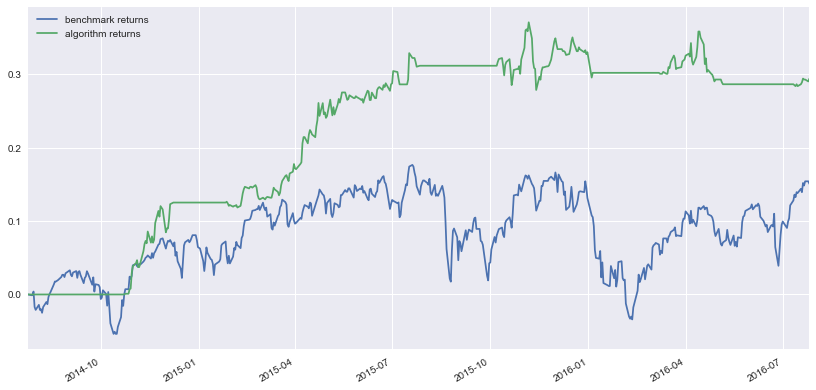

In [11]:
from abupy import AbuMetricsBase 
metrics = AbuMetricsBase(orders_pd, action_pd, capital, benchmark)
metrics.fit_metrics()
metrics.plot_returns_cmp(only_show_returns=True)

### 2. 自定义仓位管理策略的实现

上面使用AbuMetricsBase进行度量，我们计算出：

1. 胜率:41.79%
2. 平均获利期望:12.01%
3. 平均亏损期望:-4.91%
    
有这三个参数就可以使用kelly公式来做仓位控制，AbuKellyPosition实现如下：

In [12]:
class AbuKellyPosition(AbuPositionBase):
    """示例kelly仓位管理类"""

    def fit_position(self, factor_object):
        """
        fit_position计算的结果是买入多少个单位（股，手，顿，合约）
        需要factor_object策略因子对象通过历史回测统计胜率，期望收益，期望亏损，
        并设置构造当前factor_object对象，通过kelly公司计算仓位
        :param factor_object: ABuFactorBuyBases子类实例对象
        :return:买入多少个单位（股，手，顿，合约）
        """
        # 败率
        loss_rate = 1 - self.win_rate
        # kelly计算出仓位比例
        kelly_pos = self.win_rate - loss_rate / (self.gains_mean / self.losses_mean)
        # 最大仓位限制，依然受上层最大仓位控制限制，eg：如果kelly计算出全仓，依然会减少到75%，如修改需要修改最大仓位值
        kelly_pos = self.pos_max if kelly_pos > self.pos_max else kelly_pos
        # 结果是买入多少个单位（股，手，顿，合约）
        return self.read_cash * kelly_pos / self.bp * self.deposit_rate

    def _init_self(self, **kwargs):
        """kelly仓位控制管理类初始化设置"""

        # 默认kelly仓位胜率0.50
        self.win_rate = kwargs.pop('win_rate', 0.50)
        # 默认平均获利期望0.10
        self.gains_mean = kwargs.pop('gains_mean', 0.10)
        # 默认平均亏损期望0.05
        self.losses_mean = kwargs.pop('losses_mean', 0.05)

        """以默认的设置kelly根据计算0.5 - 0.5 / (0.10 / 0.05) 仓位将是0.25即25%"""

自定义仓位管理代码如上AbuKellyPosition：

1. 仓位管理类需要继承AbuPositionBase
2. 仓位管理类主要需要实现函数fit_position，即根据买入价格，本金基数等融合买入策略对买入单位进行计算
3. 仓位管理类主要需要实现函数_init_self，外部通过字典参数将胜率等参数进行关键子参数设置（详见后使用示例）

更多资金管理代码请阅读AbuPositionBase

下面编写buy_factors2，其42d突破使用position＝AbuKellyPosition

* 参数胜率：metrics.win_rate(41.79%)
* 期望收益：metrics.gains_mean(12.01%)
* 期望亏损：metrics.losses_mean(-4.91%)，

代码如下所示：

In [13]:
from abupy import AbuKellyPosition

# 42d使用刚刚编写的AbuKellyPosition，60d仍然使用默认仓位管理类，即abupy中内置的AbuAtrPosition类
buy_factors2 = [{'xd': 60, 'class': AbuFactorBuyBreak},
                {'xd': 42, 'position': {'class': AbuKellyPosition, 'win_rate': metrics.win_rate, 
                                        'gains_mean': metrics.gains_mean, 'losses_mean': -metrics.losses_mean},
                 'class': AbuFactorBuyBreak}]

capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, all_fit_symbols_cnt = ABuPickTimeExecute.do_symbols_with_same_factors(choice_symbols,
                                                                                            benchmark,
                                                                                            buy_factors2,
                                                                                            sell_factors,
                                                                                            capital,
                                                                                            show=False)

从输出生成的orders_pd中可以看到buy Pos列所有42d突破都使用了AbuKellyPosition，60d仍然使用AbuAtrPosition

In [14]:
orders_pd[:10].filter(['symbol', 'buy_cnt', 'buy_factor', 'buy_pos'])

,symbol,buy_cnt,buy_factor,buy_pos
2014-10-24,usAAPL,1904.0,AbuFactorBuyBreak:60,AbuAtrPosition
2014-10-24,usAAPL,1962.0,AbuFactorBuyBreak:42,AbuKellyPosition
2014-10-29,usBIDU,921.0,AbuFactorBuyBreak:42,AbuKellyPosition
2014-10-29,usNOAH,12875.0,AbuFactorBuyBreak:42,AbuKellyPosition
2014-10-29,usVIPS,9618.0,AbuFactorBuyBreak:42,AbuKellyPosition
2014-10-29,usBIDU,781.0,AbuFactorBuyBreak:60,AbuAtrPosition
2014-11-03,usVIPS,5900.0,AbuFactorBuyBreak:60,AbuAtrPosition
2014-11-11,usNOAH,9491.0,AbuFactorBuyBreak:60,AbuAtrPosition
2014-11-12,usWUBA,4765.0,AbuFactorBuyBreak:42,AbuKellyPosition
2014-11-26,usWUBA,3262.0,AbuFactorBuyBreak:60,AbuAtrPosition


### 3. 多支股票使用不同的因子进行择时 

使用ABuPickTimeExecute.do_symbols_with_diff_factors()函数针对不同的股票使用不同的买入因子和不同的卖出因子，

具体实现请查阅源代码ABuPickTimeExecute，使用示例如下：

In [15]:
# 选定noah和sfun
target_symbols = ['usSFUN', 'usNOAH']

# 针对sfun只使用42d向上突破作为买入因子
buy_factors_sfun = [{'xd': 42, 'class': AbuFactorBuyBreak}]
# 针对sfun只使用60d向下突破作为卖出因子
sell_factors_sfun = [{'xd': 60, 'class': AbuFactorSellBreak}]

# 针对noah只使用21d向上突破作为买入因子
buy_factors_noah = [{'xd': 21, 'class': AbuFactorBuyBreak}]
# 针对noah只使用42d向下突破作为卖出因子
sell_factors_noah = [{'xd': 42, 'class': AbuFactorSellBreak}]

factor_dict = dict()
# 构建SFUN独立的buy_factors，sell_factors的dict
factor_dict['usSFUN'] = {'buy_factors': buy_factors_sfun,
                         'sell_factors': sell_factors_sfun}

# 构建NOAH独立的buy_factors，sell_factors的dict
factor_dict['usNOAH'] = {'buy_factors': buy_factors_noah,
                         'sell_factors': sell_factors_noah}

# 初始化资金
capital = AbuCapital(1000000, benchmark)
# 使用do_symbols_with_diff_factors执行
orders_pd, action_pd, all_fit_symbols = ABuPickTimeExecute.do_symbols_with_diff_factors(target_symbols,
                                                                                        benchmark,
                                                                                        factor_dict,
                                                                                        capital)

如下代码通过pandas的交叉表来分析输出的orders_pd， 来证明: noah买入因子全部是使用21d向上突破，sfun买入因子全部是使用42d向上突破：

In [16]:
pd.crosstab(orders_pd.buy_factor, orders_pd.symbol)

symbol,usNOAH,usSFUN
buy_factor,,
AbuFactorBuyBreak:21,9,0
AbuFactorBuyBreak:42,0,4


### 4. 使用并行来提升择时运行效率

当你选择的股票非常多的时候，比如很多时候是对全市场进行回测，那就需要多进程并行来提升运行效率，AbuPickTimeMaster.do_symbols_with_same_factors_process()函数通过定义n_process_kl（同时获取股票数据的进程数）和n_process_pick_time（同时进行择时的进程数）来完成操作.

具体实现代码请阅读AbuPickTimeMaster，使用示例如下所示：

In [17]:
%%time
from abupy import AbuPickTimeMaster

capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, _ = AbuPickTimeMaster.do_symbols_with_same_factors_process(
                                    choice_symbols, benchmark, buy_factors, sell_factors, capital,
                                    n_process_kl=4, n_process_pick_time=4)

CPU times: user 2.68 s, sys: 223 ms, total: 2.91 s
Wall time: 11.9 s


依然使用%%time度量代码块运行时间，之前使用开始时使用ABuPickTimeExecute运行相同的回测输出运行时间18.3 s，
使用AbuPickTimeMaster使用参数n_process_pick_time=8，即启动8个择时进程后，运行时间缩短到6.36s，从输出的信息也可以看到8个pid同时进行
择时

- pid:84544 pick times complete:100.0%
- pid:84545 pick times complete:100.0%
- pid:84546 pick times complete:100.0%
- pid:84547 pick times complete:100.0%
- pid:84548 pick times complete:100.0%
- pid:84549 pick times complete:100.0%
- pid:84550 pick times complete:100.0%
- pid:84551 pick times complete:100.0%

多进程的运行方式在进行多支股票设置全市场策略回测时是非常有用的，本节由于choice_symbols中的股票数少，n_process_kl即并行金融数据采集模块
并没有使用，还有一些需要注意的地方也还没有讲到，在后续的全市场回测章节讲继续讲解。

备注: 

**由于本例开辟进程数较多，但是每个进程处理的任务非常少，所以在cpu不够快的电脑上结果可能正好相反，多进程模式的运行也行会更加耗时，效率更低，属正常现象，后面的例子每个进程可能会处理几十几百个交易对象就不会出现创建销毁进程的开销大于任务执行时间的情况**

* 特别是windows系统，mac上不会发生，由于mac上的并行使用joblib，在windows上长任务joblib存在bug，所以windows上并行只是封装为joblib的接口形式，详情阅读源代码ABuParallel

#### abu量化文档目录章节

1. [择时策略的开发](http://www.abuquant.com/lecture/lecture_1.html)
2. [择时策略的优化](http://www.abuquant.com/lecture/lecture_2.html)
3. [滑点策略与交易手续费](http://www.abuquant.com/lecture/lecture_3.html)
4. [多支股票择时回测与仓位管理](http://www.abuquant.com/lecture/lecture_4.html)
5. [选股策略的开发](http://www.abuquant.com/lecture/lecture_5.html)
6. [回测结果的度量](http://www.abuquant.com/lecture/lecture_6.html)
7. [寻找策略最优参数和评分](http://www.abuquant.com/lecture/lecture_7.html)
8. [A股市场的回测](http://www.abuquant.com/lecture/lecture_8.html)
9. [港股市场的回测](http://www.abuquant.com/lecture/lecture_9.html)
10. [比特币，莱特币的回测](http://www.abuquant.com/lecture/lecture_10.html)
11. [期货市场的回测](http://www.abuquant.com/lecture/lecture_11.html)
12. [机器学习与比特币示例](http://www.abuquant.com/lecture/lecture_12.html)
13. [量化技术分析应用](http://www.abuquant.com/lecture/lecture_13.html)
14. [量化相关性分析应用](http://www.abuquant.com/lecture/lecture_14.html)
15. [量化交易和搜索引擎](http://www.abuquant.com/lecture/lecture_15.html)
16. [UMP主裁交易决策](http://www.abuquant.com/lecture/lecture_16.html)
17. [UMP边裁交易决策](http://www.abuquant.com/lecture/lecture_17.html)
18. [自定义裁判决策交易](http://www.abuquant.com/lecture/lecture_18.html)
19. [数据源](http://www.abuquant.com/lecture/lecture_19.html)
20. [A股全市场回测](http://www.abuquant.com/lecture/lecture_20.html)
21. [A股UMP决策](http://www.abuquant.com/lecture/lecture_21.html)
22. [美股全市场回测](http://www.abuquant.com/lecture/lecture_22.html)
23. [美股UMP决策](http://www.abuquant.com/lecture/lecture_23.html)
abu量化系统文档教程持续更新中，请关注公众号中的更新提醒。

#### 《量化交易之路》目录章节及随书代码地址

1. [第二章 量化语言——Python](https://github.com/bbfamily/abu/tree/master/ipython/第二章-量化语言——Python.ipynb)
2. [第三章 量化工具——NumPy](https://github.com/bbfamily/abu/tree/master/ipython/第三章-量化工具——NumPy.ipynb)
3. [第四章 量化工具——pandas](https://github.com/bbfamily/abu/tree/master/ipython/第四章-量化工具——pandas.ipynb)
4. [第五章 量化工具——可视化](https://github.com/bbfamily/abu/tree/master/ipython/第五章-量化工具——可视化.ipynb)
5. [第六章 量化工具——数学：你一生的追求到底能带来多少幸福](https://github.com/bbfamily/abu/tree/master/ipython/第六章-量化工具——数学.ipynb)
6. [第七章 量化系统——入门：三只小猪股票投资的故事](https://github.com/bbfamily/abu/tree/master/ipython/第七章-量化系统——入门.ipynb)
7. [第八章 量化系统——开发](https://github.com/bbfamily/abu/tree/master/ipython/第八章-量化系统——开发.ipynb)
8. [第九章 量化系统——度量与优化](https://github.com/bbfamily/abu/tree/master/ipython/第九章-量化系统——度量与优化.ipynb)
9. [第十章 量化系统——机器学习•猪老三](https://github.com/bbfamily/abu/tree/master/ipython/第十章-量化系统——机器学习•猪老三.ipynb)
10. [第十一章 量化系统——机器学习•ABU](https://github.com/bbfamily/abu/tree/master/ipython/第十一章-量化系统——机器学习•ABU.ipynb)
11. [附录A 量化环境部署](https://github.com/bbfamily/abu/tree/master/ipython/附录A-量化环境部署.ipynb)
12. [附录B 量化相关性分析](https://github.com/bbfamily/abu/tree/master/ipython/附录B-量化相关性分析.ipynb)
13. [附录C 量化统计分析及指标应用](https://github.com/bbfamily/abu/tree/master/ipython/附录C-量化统计分析及指标应用.ipynb)


[更多阿布量化量化技术文章](http://www.abuquant.com/article)


更多关于量化交易相关请阅读[《量化交易之路》](http://www.abuquant.com/books/quantify-trading-road.html)

更多关于量化交易与机器学习相关请阅读[《机器学习之路》](http://www.abuquant.com/books/machine-learning-road.html)

更多关于abu量化系统请关注微信公众号: abu_quant

如有任何问题也可在公众号中联系我的个人微信号。

![](./image/qrcode.jpg)